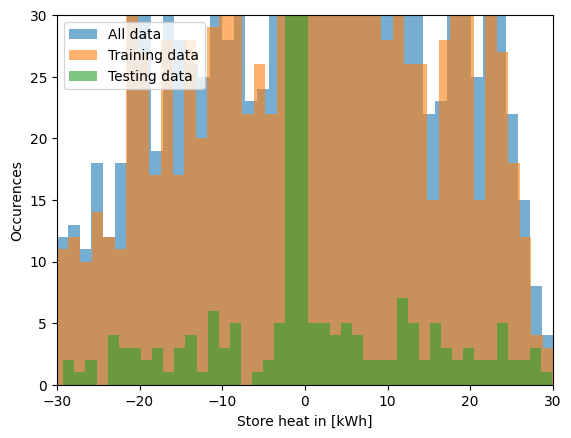

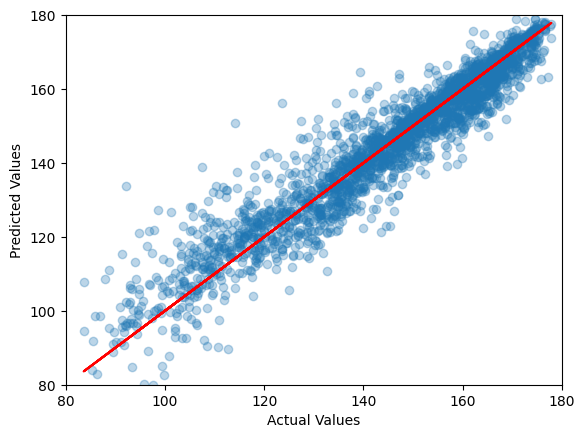

RMSE: 6.4
R-squared: 0.9
Cross-Validation RMSE: 6.8


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

df = pd.read_csv('oak_storage_data.csv')
X = df[[c for c in df.columns if 'initial' in c or 'store_heat_in' in c]]
y = df[[c for c in df.columns if 'final' in c]]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

plt.hist(df['store_heat_in'], bins=50, label="All data", alpha=0.6)
plt.hist(X_train['store_heat_in'], bins=50, label="Training data", alpha=0.6)
plt.hist(X_test['store_heat_in'], bins=50, label="Testing data", alpha=0.6)
plt.xlabel("Store heat in [kWh]")
plt.ylabel("Occurences")
plt.xlim([-30,30])
plt.ylim([0,30])
plt.legend()
plt.show()

ridge_model = Ridge(alpha=1.0)
ridge_model.fit(X_train, y_train)
y_pred_ridge = ridge_model.predict(X_test)

plt.scatter(y_test, y_pred_ridge, alpha=0.3)
plt.plot(y_test, y_test, color='red')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.xlim([80,180])
plt.ylim([80,180])
plt.show()

mse_ridge = mean_squared_error(y_test, y_pred_ridge)
r2_ridge = r2_score(y_test, y_pred_ridge)
ridge_cv_score = cross_val_score(ridge_model, X, y, cv=5, scoring='neg_mean_squared_error')
print(f"RMSE: {round(np.sqrt(abs(mse_ridge)),1)}")
print(f"R-squared: {round(r2_ridge,1)}")
print(f"Cross-Validation RMSE: {round(np.sqrt(abs(ridge_cv_score.mean())),1)}")

In [2]:
def kmeans(data, k=3, max_iters=100, tol=1e-4):
    data = np.array(data).reshape(-1, 1)
    centroids = data[np.random.choice(len(data), k, replace=False)]
    for _ in range(max_iters):
        labels = np.argmin(np.abs(data - centroids.T), axis=1)
        new_centroids = np.zeros_like(centroids)
        for i in range(k):
            cluster_points = data[labels == i]
            if len(cluster_points) > 0:
                new_centroids[i] = cluster_points.mean()
            else:
                new_centroids[i] = data[np.random.choice(len(data))]
        if np.all(np.abs(new_centroids - centroids) < tol):
            break
        centroids = new_centroids
    return labels

def get_model_from_temperatures(tank_temps):
    if isinstance(tank_temps, list):
        tank_temps = {
            f'tank{tank}-depth{depth}': tank_temps[tank*4 + depth] for tank in range(3) for depth in range(4)
        }

    # Process layer temperatures
    layer_temps = [tank_temps[key] for key in tank_temps]
    iter_count = 0
    print(f"Before processing: {layer_temps}")
    while (sorted(layer_temps, reverse=True) != layer_temps and iter_count<20):
        iter_count += 1
        layer_temps = []
        for layer in tank_temps:
            if layer_temps:
                if tank_temps[layer] > layer_temps[-1]:
                    mean = round((layer_temps[-1] + tank_temps[layer]) / 2)
                    layer_temps[-1] = mean
                    layer_temps.append(mean)
                else:
                    layer_temps.append(tank_temps[layer])
            else:
                layer_temps.append(tank_temps[layer])
        for i, layer in enumerate(tank_temps):
            tank_temps[layer] = layer_temps[i]
        if iter_count == 20:
            layer_temps = sorted(layer_temps, reverse=True)
    print(f"After processing: {layer_temps}")

    # Cluster 10 times and select the clustering with the highest top temperature
    data = layer_temps.copy()
    clustering_runs = []
    for i in range(10):
        labels = kmeans(data, k=3)
        cluster_0 = sorted([data[i] for i in range(len(data)) if labels[i] == 0], reverse=True)
        cluster_1 = sorted([data[i] for i in range(len(data)) if labels[i] == 1], reverse=True)
        cluster_2 = sorted([data[i] for i in range(len(data)) if labels[i] == 2], reverse=True)
        cluster_top = max(cluster_0, cluster_1, cluster_2, key=lambda x: np.mean(x) if len(x)>0 else 0)
        top_temp = sum(cluster_top)/len(cluster_top)
        clustering_runs.append({
            'cluster_0': cluster_0,
            'cluster_1': cluster_1,
            'cluster_2': cluster_2,
            'top_temp': top_temp
        })
    best_run = max(clustering_runs, key=lambda x: x['top_temp'])
    cluster_0 = best_run['cluster_0']
    cluster_1 = best_run['cluster_1']
    cluster_2 = best_run['cluster_2']

    # Dealing with 3 clusters
    if cluster_0 and cluster_1 and cluster_2:
        cluster_top = max(cluster_0, cluster_1, cluster_2, key=lambda x: sum(x)/len(x))
        cluster_bottom = min(cluster_0, cluster_1, cluster_2, key=lambda x: sum(x)/len(x))
        cluster_middle = [
            cluster_x for cluster_x in [cluster_0, cluster_1, cluster_2]
            if cluster_x != cluster_top
            and cluster_x != cluster_bottom
            ][0]
        print(f"{cluster_top}, {cluster_middle}, {cluster_bottom}")

        thermocline1 = max(1, len(cluster_top))
        thermocline2 = thermocline1 + len(cluster_middle)
        print(f"Thermocline 1: {thermocline1}/12, thermocline 2: {thermocline2}/12")

        top_temp = round(sum(cluster_top)/len(cluster_top))
        middle_temp = round(sum(cluster_middle)/len(cluster_middle))
        bottom_temp = round(sum(cluster_bottom)/len(cluster_bottom))
        print(f"{top_temp}({thermocline1}){middle_temp}({thermocline2}){bottom_temp}")
        return top_temp, middle_temp, bottom_temp, thermocline1, thermocline2

    # Dealing with less than 3 clusters
    else:
        if cluster_0 and cluster_2:
            cluster_1 = cluster_2
        elif cluster_1 and cluster_2:
            cluster_0 = cluster_2
        # Two clusters
        if cluster_0 and cluster_1:
            cluster_top = max(cluster_0, cluster_1, key=lambda x: sum(x)/len(x))
            cluster_bottom = min(cluster_0, cluster_1, key=lambda x: sum(x)/len(x))
            thermocline1 = len(cluster_top)
            top_temp = round(sum(cluster_top)/len(cluster_top))
            bottom_temp = round(sum(cluster_bottom)/len(cluster_bottom))
            print(f"{top_temp}({thermocline1}){bottom_temp}")
            return top_temp, None, bottom_temp, thermocline1, None
        # Single cluster
        else:
            cluster_top = max(cluster_0, cluster_1, cluster_2, key=lambda x: len(x))
            top_temp = round(sum(cluster_top)/len(cluster_top))
            thermocline1 = 12
            print(f"{top_temp}({thermocline1})")
            return top_temp, None, None, thermocline1, None

In [3]:
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize

class TankStatePlotter():
    def __init__(self, initial, final, predicted, store_heat_in):
        self.initial = initial
        self.final = final
        self.predicted = predicted
        self.title = f"To storage: {store_heat_in} kWh"
        self.plot()

    def plot(self):
        overall_min = min(min(self.initial), min(self.final), min(self.predicted))
        overall_max = max(max(self.initial), max(self.final), max(self.predicted))
        norm = Normalize(vmin=overall_min, vmax=overall_max)
        cmap = matplotlib.colormaps['Reds'] 

        for i in range(12):
            layer_color = cmap(norm(self.initial[i]))
            plt.bar([0], 1, bottom=11-i, color=layer_color, width=0.8)
            plt.text(0, 11-i+0.5, f'{self.initial[i]}', ha='center', va='center', color='black', alpha=0.5)

            layer_color = cmap(norm(self.final[i]))
            plt.bar([1], 1, bottom=11-i, color=layer_color, width=0.8)
            plt.text(1, 11-i+0.5, f'{self.final[i]}', ha='center', va='center', color='black', alpha=0.5)

            layer_color = cmap(norm(self.predicted[i]))
            plt.bar([3], 1, bottom=11-i, color=layer_color, width=0.8)
            plt.text(3, 11-i+0.5, f'{self.predicted[i]}', ha='center', va='center', color='black', alpha=0.5)

        top_temp, middle_temp, bottom_temp, thermocline1, thermocline2 = get_model_from_temperatures(self.final)
        top_color = cmap(norm(top_temp))
        middle_color = cmap(norm(middle_temp))
        bottom_color = cmap(norm(bottom_temp))
        
        plt.bar([2], height=thermocline1, bottom=12-thermocline1, color=top_color, width=0.8)
        plt.text(2, 12-thermocline1+thermocline1/2, f'{top_temp}', ha='center', va='center', color='black', alpha=0.5)
        plt.bar([2], height=thermocline2-thermocline1, bottom=12-thermocline2, color=middle_color, width=0.8)
        plt.text(2, 12-thermocline2+(thermocline2-thermocline1)/2, f'{middle_temp}', ha='center', va='center', color='black', alpha=0.5)
        plt.bar([2], height=12-thermocline2, bottom=0, color=bottom_color, width=0.8)
        plt.text(2, (12-thermocline2)/2, f'{bottom_temp}', ha='center', va='center', color='black', alpha=0.5)

        top_temp, middle_temp, bottom_temp, thermocline1, thermocline2 = get_model_from_temperatures(self.predicted)
        top_color = cmap(norm(top_temp))
        middle_color = cmap(norm(middle_temp))
        bottom_color = cmap(norm(bottom_temp))
        
        plt.bar([4], height=thermocline1, bottom=12-thermocline1, color=top_color, width=0.8)
        plt.text(4, 12-thermocline1+thermocline1/2, f'{top_temp}', ha='center', va='center', color='black', alpha=0.5)
        plt.bar([4], height=thermocline2-thermocline1, bottom=12-thermocline2, color=middle_color, width=0.8)
        plt.text(4, 12-thermocline2+(thermocline2-thermocline1)/2, f'{middle_temp}', ha='center', va='center', color='black', alpha=0.5)
        plt.bar([4], height=12-thermocline2, bottom=0, color=bottom_color, width=0.8)
        plt.text(4, (12-thermocline2)/2, f'{bottom_temp}', ha='center', va='center', color='black', alpha=0.5)

        plt.xticks([0,1,2,3,4], ['Before', 'After', '-', 'Predicted After', '-'])
        plt.yticks([])
        plt.title(self.title, fontsize=12)
        plt.show()



Before processing: [141.7, 134.0, 137.2, 128.0, 123.7, 109.0, 107.5, 107.2, 107.4, 105.3, 102.1, 106.5]
After processing: [141.7, 136, 136, 128.0, 123.7, 109.0, 107.5, 107, 107, 105.3, 104, 104]
[141.7], [136, 136, 128.0, 123.7], [109.0, 107.5, 107, 107, 105.3, 104, 104]
Thermocline 1: 1/12, thermocline 2: 5/12
142(1)131(5)106
Before processing: [141.4, 133.2, 134.6, 129.2, 132.1, 125.1, 113.3, 106.2, 107.3, 97.9, 93.0, 96.1]
After processing: [141.4, 134, 134, 131, 131, 125.1, 113.3, 107, 107, 97.9, 95, 95]
[141.4, 134, 134], [131, 131, 125.1], [113.3, 107, 107, 97.9, 95, 95]
Thermocline 1: 3/12, thermocline 2: 6/12
136(3)129(6)103


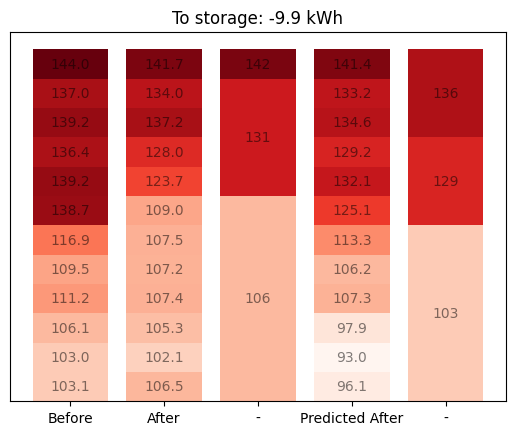


Before processing: [174.1, 165.8, 171.1, 166.2, 170.9, 171.6, 169.4, 142.3, 133.4, 114.5, 110.3, 119.3]
After processing: [174.1, 170, 170, 169.4, 169, 168, 168, 142.3, 133.4, 115, 115, 115]
[174.1], [170, 170, 169.4, 169, 168, 168], [142.3, 133.4, 115, 115, 115]
Thermocline 1: 1/12, thermocline 2: 7/12
174(1)169(7)124
Before processing: [169.7, 159.4, 163.0, 157.9, 164.2, 160.4, 156.9, 146.3, 147.5, 133.3, 123.9, 126.4]
After processing: [169.7, 161, 161, 161, 161, 160.4, 156.9, 147, 147, 133.3, 125, 125]
[169.7], [161, 161, 161, 161, 160.4, 156.9, 147, 147], [133.3, 125, 125]
Thermocline 1: 1/12, thermocline 2: 9/12
170(1)157(9)128


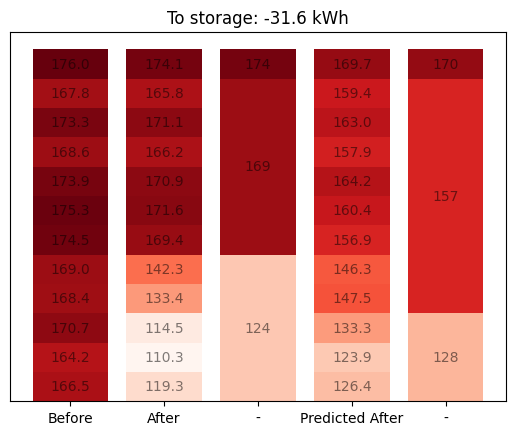



Before processing: [146.2, 138.7, 144.1, 138.6, 142.3, 140.8, 135.1, 105.4, 106.4, 99.4, 96.6, 112.7]
After processing: [146.2, 141, 141, 140, 140, 140, 135.1, 106, 106, 104, 104, 104]
[146.2], [141, 141, 140, 140, 140, 135.1], [106, 106, 104, 104, 104]
Thermocline 1: 1/12, thermocline 2: 7/12
146(1)140(7)105
Before processing: [145.5, 137.4, 140.7, 135.7, 139.4, 136.7, 133.0, 122.0, 120.7, 106.4, 99.1, 89.6]
After processing: [145.5, 139, 139, 138, 138, 136.7, 133.0, 122.0, 120.7, 106.4, 99.1, 89.6]
[145.5], [139, 139, 138, 138, 136.7, 133.0], [122.0, 120.7, 106.4, 99.1, 89.6]
Thermocline 1: 1/12, thermocline 2: 7/12
146(1)137(7)108


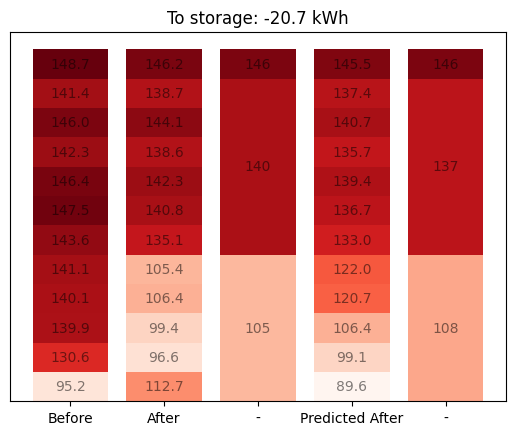




Before processing: [175.2, 167.3, 172.1, 167.6, 167.8, 168.3, 165.8, 162.6, 160.0, 162.3, 156.1, 173.1]
After processing: [175.2, 170, 170, 168, 168, 168, 165.8, 164, 164, 163, 162.6, 162]
[175.2], [170, 170, 168, 168, 168, 165.8], [164, 164, 163, 162.6, 162]
Thermocline 1: 1/12, thermocline 2: 7/12
175(1)168(7)163
Before processing: [173.3, 164.7, 169.0, 165.0, 168.0, 170.6, 169.9, 164.6, 163.0, 165.4, 157.1, 168.0]
After processing: [173.3, 168, 168, 168, 168, 168, 168, 164.6, 164, 164, 163, 163]
[173.3], [168, 168, 168, 168, 168, 168], [164.6, 164, 164, 163, 163]
Thermocline 1: 1/12, thermocline 2: 7/12
173(1)168(7)164


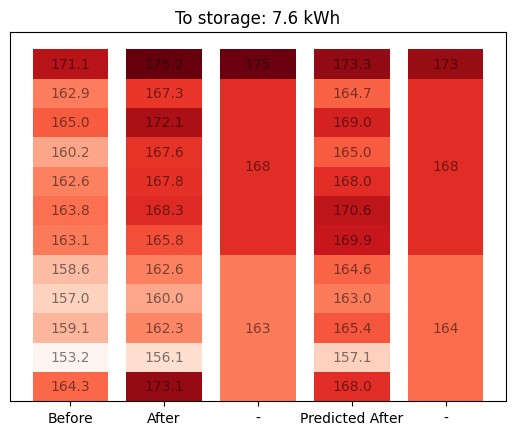







Before processing: [176.6, 167.8, 172.7, 169.4, 174.3, 173.8, 170.5, 168.9, 164.8, 163.7, 126.1, 127.4]
After processing: [176.6, 172, 172, 172, 171, 170.5, 170, 168.9, 164.8, 163.7, 127, 127]
[176.6], [172, 172, 172, 171, 170.5, 170, 168.9, 164.8, 163.7], [127, 127]
Thermocline 1: 1/12, thermocline 2: 10/12
177(1)169(10)127
Before processing: [176.2, 166.9, 171.1, 167.1, 171.8, 171.3, 168.2, 160.7, 158.1, 151.1, 142.1, 151.3]
After processing: [176.2, 170, 170, 170, 170, 170, 168.2, 160.7, 158.1, 151.1, 147, 147]
[176.2], [170, 170, 170, 170, 170, 168.2], [160.7, 158.1, 151.1, 147, 147]
Thermocline 1: 1/12, thermocline 2: 7/12
176(1)170(7)153


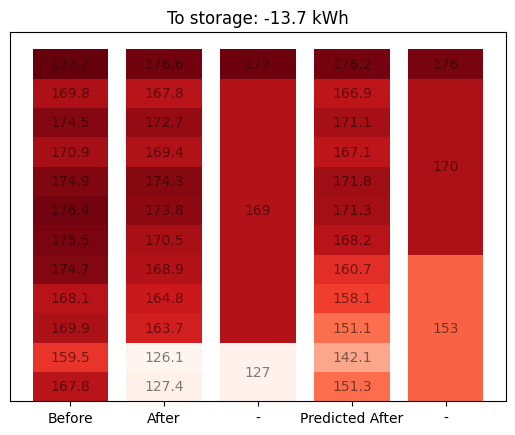



Before processing: [156.5, 147.9, 150.4, 146.2, 151.0, 150.6, 138.4, 107.4, 116.2, 102.2, 99.5, 111.8]
After processing: [156.5, 150, 150, 150, 150, 150, 138.4, 112, 112, 104, 104, 104]
[156.5], [150, 150, 150, 150, 150, 138.4], [112, 112, 104, 104, 104]
Thermocline 1: 1/12, thermocline 2: 7/12
156(1)148(7)107
Before processing: [155.6, 146.5, 150.4, 146.0, 149.5, 144.2, 137.5, 126.3, 125.2, 99.4, 94.8, 102.8]
After processing: [155.6, 148, 148, 148, 148, 144.2, 137.5, 126.3, 125.2, 99.4, 99, 99]
[155.6], [148, 148, 148, 148, 144.2, 137.5], [126.3, 125.2, 99.4, 99, 99]
Thermocline 1: 1/12, thermocline 2: 7/12
156(1)146(7)110


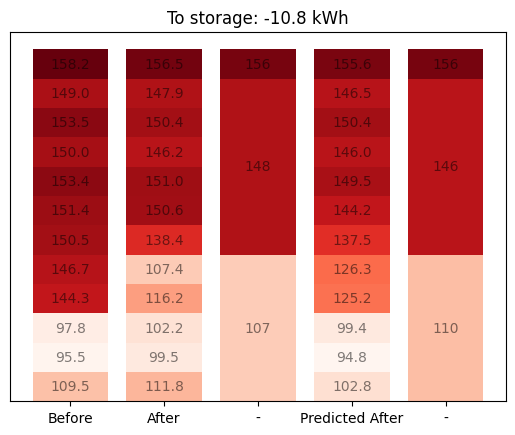



Before processing: [166.4, 156.7, 157.9, 150.9, 153.5, 154.7, 154.0, 153.2, 150.2, 152.3, 146.8, 159.5]
After processing: [166.4, 157, 157, 154, 154, 153.2, 153, 152, 152, 152, 152, 152]
[166.4], [157, 157], [154, 154, 153.2, 153, 152, 152, 152, 152, 152]
Thermocline 1: 1/12, thermocline 2: 3/12
166(1)157(3)153
Before processing: [163.1, 154.6, 158.6, 152.6, 152.3, 154.3, 154.0, 152.9, 150.6, 155.1, 147.8, 159.8]
After processing: [163.1, 157, 157, 154, 154, 154, 154, 154, 154, 154, 154, 154]
[163.1], [157, 157], [154, 154, 154, 154, 154, 154, 154, 154, 154]
Thermocline 1: 1/12, thermocline 2: 3/12
163(1)157(3)154


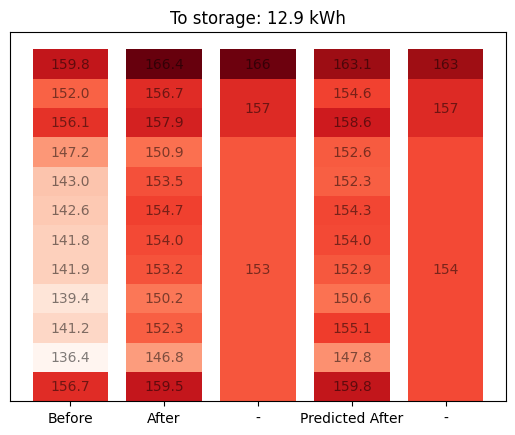


Before processing: [166.2, 156.4, 153.3, 141.2, 147.1, 148.4, 148.0, 147.7, 147.0, 149.1, 143.8, 156.9]
After processing: [166.2, 156.4, 153.3, 150, 150, 149, 148, 147, 146, 146, 146, 146]
[166.2], [156.4, 153.3, 150, 150], [149, 148, 147, 146, 146, 146, 146]
Thermocline 1: 1/12, thermocline 2: 5/12
166(1)152(5)147
Before processing: [168.1, 161.3, 166.0, 159.6, 162.9, 157.6, 139.0, 134.4, 138.7, 139.2, 134.1, 144.2]
After processing: [168.1, 164, 164, 161, 161, 157.6, 139.0, 138, 138, 138, 138, 138]
[168.1], [164, 164, 161, 161, 157.6], [139.0, 138, 138, 138, 138, 138]
Thermocline 1: 1/12, thermocline 2: 6/12
168(1)162(6)138


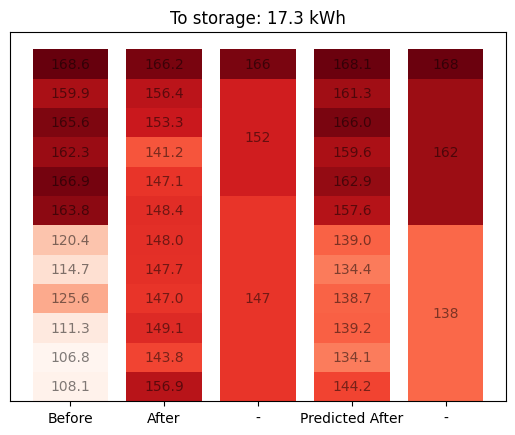


Before processing: [155.0, 148.7, 153.4, 150.7, 156.3, 157.7, 157.0, 155.7, 149.0, 148.6, 130.7, 147.7]
After processing: [156, 156, 155.7, 155.0, 155, 154, 153, 152, 149.0, 148.6, 139, 139]
[156, 156, 155.7, 155.0, 155, 154, 153], [152, 149.0, 148.6], [139, 139]
Thermocline 1: 7/12, thermocline 2: 10/12
155(7)150(10)139
Before processing: [154.3, 145.4, 149.2, 146.3, 150.5, 153.4, 152.5, 151.3, 148.9, 154.2, 145.8, 158.6]
After processing: [154.3, 152, 152, 152, 152, 152, 152, 152, 151, 150, 149, 148]
[154.3], [152, 152, 152, 152, 152, 152, 152, 151], [150, 149, 148]
Thermocline 1: 1/12, thermocline 2: 9/12
154(1)152(9)149


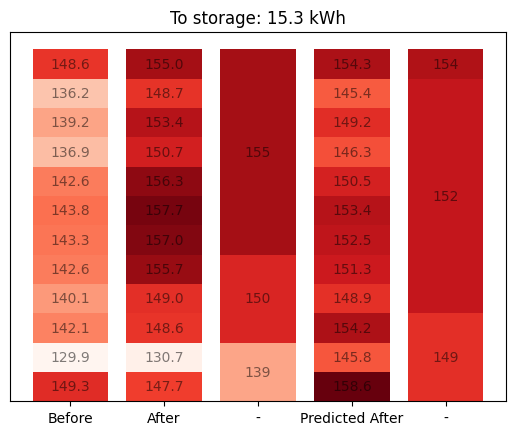

In [4]:
for i in range(20):
    print('')
    store_heat_in = X_test.iloc[i].tolist()[0]
    if abs(store_heat_in) < 2:
        continue
    initial_temp = X_test.iloc[i].tolist()[1:]
    final_temp = y_test.iloc[i].tolist()
    final_temp_pred = [round(float(x),1) for x in list(y_pred_ridge[i])]
    t = TankStatePlotter(initial_temp, final_temp, final_temp_pred, store_heat_in)